## Import Pythonic Libraries
This notebook should be run at [swan.cern.ch](swan.cern.ch).  The notebook parameters used are:
- Python 3
- Software stack: 97
- Platform: CentOS 7 (gcc9)
- Number of cores: 2 or 4
- Memory: 8 or 10 GB

Requires downloading `root` samples (within a directory) to the working directory hosting this notebook.

In [1]:
import os, sys
import mplhep as hep
import seaborn as sns
import time
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc
import ROOT
import matplotlib.pyplot as plt
import matplotlib.gridspec as gdsc
import ipywidgets as widgets
from ROOT import TMVA, TFile, TTree, TCut, TRandom3
from ROOT import TCanvas, TGraph
from ROOT import gSystem, gApplication, gROOT
import varsList
import mplhep as hep

plt.style.use(hep.style.CMS)
ROOT.ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.20/06


## Select the samples and variables to compare
ROOT files should be stored in a directory at the same level of this notebook.  Keep samples of different years in different directories.

In [2]:
# get list of directories in working directory
dirList = next(os.walk(os.getcwd()))[1]

# root paths
treeName = "ljmet"

In [3]:
print("Choose the first sample directory for comparison:")
sampleDirOne = widgets.Dropdown( options = dirList )
sampleDirOne

Choose the first sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

In [5]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirOne.value ))
sampleOne = widgets.SelectMultiple( options = os.listdir( sampleDirOne.value ) )
sampleOne

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2017_Oct2019_4t_08122020_step2:


SelectMultiple(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweight…

In [6]:
print("Choose the second sample directory for comparison:")
sampleDirTwo = widgets.Dropdown( options = dirList )
sampleDirTwo

Choose the second sample directory for comparison:


Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

In [7]:
print("Choose the samples (ctrl + mouse) from {}:".format( sampleDirTwo.value ))
sampleTwo = widgets.SelectMultiple( options = os.listdir( sampleDirTwo.value ) )
sampleTwo

Choose the samples (ctrl + mouse) from FWLJMET102X_1lep2018_Oct2019_4t_08122020_step2:


SelectMultiple(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythi…

Extract events from each ROOT file then identify shared variables between the samples and store the names as common branches.

In [8]:
rootFileOne = {}
rootTreeOne = {}
branchListOne = {}
rootFileTwo = {}
rootTreeTwo = {}
branchListTwo = {}

commonBranches = []

for file in sampleOne.value:
    rootFileOne[file] = ROOT.TFile.Open( sampleDirOne.value + "/" + file )
    rootTreeOne[file] = rootFileOne[file].Get( treeName )
    branchListOne[file] = [ branch.GetName() for branch in rootTreeOne[file].GetListOfBranches() ]

for file in sampleTwo.value:
    rootFileTwo[file] = ROOT.TFile.Open( sampleDirTwo.value + "/" + file )
    rootTreeTwo[file] = rootFileTwo[file].Get( treeName )
    branchListTwo[file] = [ branch.GetName() for branch in rootTreeTwo[file].GetListOfBranches() ]

for fileOne in branchListOne:
    for itr, fileTwo in enumerate(branchListTwo):
        commonBranch = set(branchListOne[fileOne]).intersection(branchListTwo[fileTwo])
        if itr == 0:
            commonBranches = commonBranch
        else:
            commonBranches = commonBranches.intersection(commonBranch)
        
    
print("{} variables shared.".format(
    len(commonBranches)
))

417 variables shared.


### Convert events to `numpy` container and Combine the root files

In [9]:
# get relevant cuts from each root file
cutOne = {}
cutTwo = {}

startTime = time.time()

for file in sampleOne.value:
    cutOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading first sample(s) in {:.2f} seconds".format(time.time()-startTime))

for file in sampleTwo.value:
    cutTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [
        "leptonPt_MultiLepCalc",
        "isElectron",
        "isMuon",
        "corr_met_MultiLepCalc",
        "MT_lepMet",
        "minDR_lepJet",
        "AK4HT",
        "DataPastTriggerX",
        "MCPastTriggerX",
        "NJetsCSVwithSF_MultiLepCalc",
        "NJets_JetSubCalc",
        "triggerXSF",
        "pileupWeight",
        "lepIdSF",
        "EGammaGsfSF",
        "isoSF",
        "L1NonPrefiringProb_CommonCalc",
        "xsecEff",
        "MCWeight_MultiLepCalc"
    ] ))
    
print("Finished loading second sample(s) in {:.2f} seconds".format(time.time()-startTime))

Finished loading first sample(s) in 29.07 seconds
Finished loading second sample(s) in 44.07 seconds


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/ROOT.py:352: FutureWarning: Instantiating a function template with parentheses ( f(type1, ..., typeN) ) is deprecated and will not be supported in a future version of ROOT. Instead, use square brackets: f[type1, ..., typeN]
  flat_matrix_ptr = _root.ROOT.Internal.RDF.GetVectorAddress(dtype)(flat_matrix)


In [10]:
cutOneComb = np.concatenate([cutOne[file] for file in sampleOne.value])
cutTwoComb = np.concatenate([cutTwo[file] for file in sampleTwo.value])

cutOneSort = np.asarray(cutOneComb[cutOneComb[:,0].argsort()])
cutTwoSort = np.asarray(cutTwoComb[cutTwoComb[:,0].argsort()])

In [11]:
cutOneSort = cutOneComb[np.lexsort((cutOneComb[:,3],cutOneComb[:,0]))]
cutTwoSort = cutTwoComb[np.lexsort((cutTwoComb[:,3],cutTwoComb[:,0]))]

##### Apply selection to the events and evaluate weights

In [12]:
# apply cuts
leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets= 2
nJets = 6

cutMaskOne = np.zeros(np.shape(cutOneSort)[0])
cutMaskTwo = np.zeros(np.shape(cutTwoSort)[0])
weightOne = np.full(np.shape(cutOneSort)[0],1.0)
weightTwo = np.full(np.shape(cutTwoSort)[0],1.0)
startTime = time.time()
for i in range(np.shape(cutOneComb)[0]):
    if ( ( cutOneSort[i,0] > leptonPt and cutOneSort[i,1] == isElectron ) or ( cutOneSort[i,0] > leptonPt and cutOneSort[i,2] == isMuon ) ):
        if ( cutOneSort[i,3] > corr_met and cutOneSort[i,4] > MT_lepMet and cutOneSort[i,5] > minDR_lepJet and cutOneSort[i,6] > AK4HT ):
            if ( int(cutOneSort[i,7]) == DataPastTriggerX and int(cutOneSort[i,8]) == MCPastTriggerX ):
                if ( int(cutOneSort[i,9]) >= bJets and int(cutOneSort[i,10]) >= nJets ):
                    cutMaskOne[i] = 1
    weightOne[i] = np.prod(cutOneSort[i,11:]) / abs(cutOneSort[i,18])
            
print("{} events out of {} passed for sample(s) one...".format(int(np.sum(cutMaskOne)),np.shape(cutOneComb)[0]))
for i in range(np.shape(cutTwoComb)[0]):
    if ( ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,1] == isElectron ) or ( cutTwoSort[i,0] > leptonPt and cutTwoSort[i,2] == isMuon ) ):
        if ( cutTwoSort[i,3] > corr_met and cutTwoSort[i,4] > MT_lepMet and float(cutTwoSort[i,5]) > minDR_lepJet and cutTwoSort[i,6] > AK4HT ):
            if ( int(cutTwoSort[i,7]) == DataPastTriggerX and int(cutTwoSort[i,8]) == MCPastTriggerX ):
                if ( int(cutTwoSort[i,9]) >= bJets and int(cutTwoSort[i,10]) >= nJets ):
                    cutMaskTwo[i] = 1
    weightTwo[i] = np.prod(cutTwoSort[i,11:]) / abs(cutTwoSort[i,18])
                    
print("{} events out of {} passed for sample(s) two...".format(int(np.sum(cutMaskTwo)),np.shape(cutTwoComb)[0]))
print("Finished after {:.2f} seconds".format(time.time()-startTime))

101381 events out of 502477 passed for sample(s) one...
110260 events out of 515423 passed for sample(s) two...
Finished after 7.27 seconds


##### Visualize the weights

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


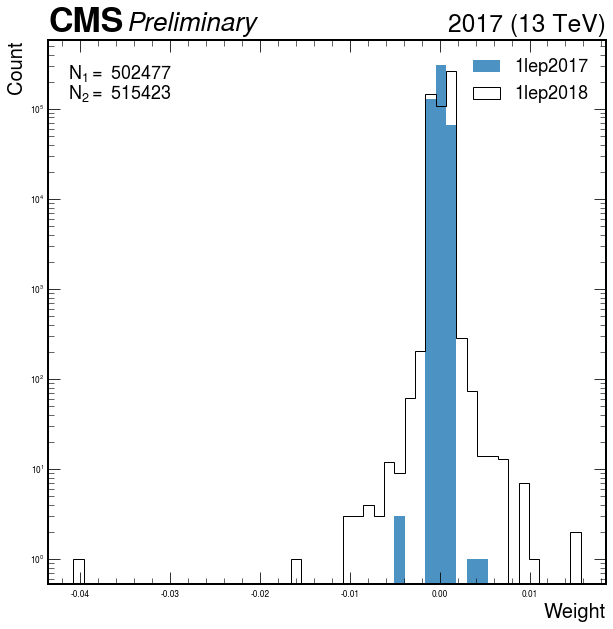

In [13]:
bins = np.linspace(min(min(weightOne),min(weightTwo)),max(max(weightOne),max(weightTwo)),50)
plt.close()
plt.figure(figsize = (10,10))
plt.hist(
    weightOne, bins=bins, label=sampleDirOne.value.split("_")[1],
    histtype="stepfilled",alpha=0.8
)
plt.hist(
    weightTwo, bins=bins, label=sampleDirTwo.value.split("_")[1],
    histtype="step",color="black"
)
plt.annotate(
    u"$N_1=$ {}".format( len( weightOne ) ),
    xycoords = "axes pixels",
    xy = (20,505),
    fontsize = 18
)
plt.annotate(
    u"$N_2=$ {}".format( len( weightTwo ) ),
    xycoords = "axes pixels",
    xy = (20,485),
    fontsize = 18
)
plt.ylabel("Count", y = 1.0, ha = "right", fontsize = 20)
plt.xlabel("Weight", x = 1.0, ha = "right", fontsize = 20)
plt.legend(loc="best", fontsize = 18)
plt.yscale("log")
plt.style.use(hep.style.CMS)
hep.cms.text("Preliminary")
hep.cms.lumitext("2017 (13 TeV)")
plt.show()

### Apply the selection mask to the desired input variable

In [14]:
print("Choose the variable to compare:")
fileList = widgets.Dropdown( options = sorted(commonBranches) )
fileList

Choose the variable to compare:


Dropdown(options=('AK4HT', 'AK4HTpMETpLepPt', 'AK4JetBTag_MultiLepCalc_PtOrdered', 'AK4JetDeepCSVb_MultiLepCal…

In [15]:
# define some plotting parameters
varIndex = np.argwhere(np.asarray(varsList.varList["DNN"])[:,0]==fileList.value)[0,0]
minBin, maxBin, nBins = varsList.varList["DNN"][varIndex][-3:]
binWidth = float( maxBin - minBin ) / float(nBins)
if len(sampleOne.value) < 2:
    sampleType = "Signal"
else:
    sampleType = "Background"

histBins = np.linspace(minBin, maxBin, nBins)

In [16]:
# populate the branches
branchOne = {}
branchTwo = {}

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    branchOne[file] = np.asarray(rootTreeOne[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))
for file in sampleTwo.value:
    branchTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( [ "leptonPt_MultiLepCalc", "corr_met_MultiLepCalc", str(fileList.value) ] ))

branchOneComb = np.concatenate([branchOne[file] for file in sampleOne.value])
branchTwoComb = np.concatenate([branchTwo[file] for file in sampleTwo.value])

branchOneSort = branchOneComb[np.lexsort((branchOneComb[:,1],branchOneComb[:,0]))][:,2]
branchTwoSort = branchTwoComb[np.lexsort((branchTwoComb[:,1],branchTwoComb[:,0]))][:,2]

branchCutOne = branchOneSort[cutMaskOne.astype(bool)]
branchCutTwo = branchTwoSort[cutMaskTwo.astype(bool)]

weightCutOne = weightOne[cutMaskOne.astype(bool)]
weightCutTwo = weightTwo[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 6.88 seconds...


### Populate histograms with weighting
Pre-selection histogram

In [17]:
histWgtOne = np.zeros(nBins)
histErrOne = [ [0] for _ in range(nBins) ]
histWgtTwo = np.zeros(nBins)
histErrTwo = [ [0] for _ in range(nBins) ]
startTime = time.time()

excludedOne = 0
excludedTwo = 0

for i, event in enumerate(branchOneSort):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtOne[index] += weightOne[i]
        histErrOne[index].append(weightOne[i]**2.)
    else:
        excludedOne += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedOne,
    minBin,
    maxBin,
    nBins
))
    
for i, event in enumerate(branchTwoSort):
    if ( event >= minBin ) and ( event < maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtTwo[index] += weightTwo[i]
        histErrTwo[index].append(weightTwo[i]**2.)
    else:
        excludedTwo += 1
print("{} events excluded from sample two with binning: ({},{},{})".format(
    excludedTwo,
    minBin,
    maxBin,
    nBins
))
            
histErrOne = np.array([np.sqrt(np.sum(i)) for i in histErrOne])
histErrTwo = np.array([np.sqrt(np.sum(i)) for i in histErrTwo])

print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

109 events excluded from sample one with binning: (0,4000,101)
112 events excluded from sample two with binning: (0,4000,101)
Finished binning in 22.63 seconds


Post-selection histogram

In [18]:
histWgtCutOne = np.zeros(nBins)
histWgtErrOne = [ [] for _ in range(nBins) ]
histWgtCutTwo = np.zeros(nBins)
histWgtErrTwo = [ [] for _ in range(nBins) ]
startTime = time.time()

excludedOne = 0
excludedTwo = 0

for i, event in enumerate(branchCutOne):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtCutOne[index] += weightCutOne[i]
        histWgtErrOne[index].append(weightCutOne[i]**2.)
    else:
        excludedOne += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedOne,
    minBin,
    maxBin,
    nBins
))

for i, event in enumerate(branchCutTwo):
    if ( event >= minBin ) and ( event <= maxBin ):
        index = np.argwhere( histBins >= event ).flatten()[0]
        histWgtCutTwo[index] += weightCutTwo[i]
        histWgtErrTwo[index].append(weightCutTwo[i]**2.)
    else:
        excludedTwo += 1
print("{} events excluded from sample one with binning: ({},{},{})".format(
    excludedTwo,
    minBin,
    maxBin,
    nBins
))


histWgtErrOne = np.array([np.sqrt(np.sum(i)) for i in histWgtErrOne])
histWgtErrTwo = np.array([np.sqrt(np.sum(i)) for i in histWgtErrTwo])
            
print("Finished binning in {:.2f} seconds".format(time.time()-startTime))

17 events excluded from sample one with binning: (0,4000,101)
18 events excluded from sample one with binning: (0,4000,101)
Finished binning in 4.65 seconds


## Plot the two distributions
The (two sample) Kolmogorov-Smirnov test is used to evaluate if the two input distributions are sampled from the same parent population. Two metrics are provided: the Kolmogrov-Smirnov statistic ($D$) and the $p$-value.  $D$ represents a determinant which determines whether the null hypothesis of being similarly sampled is rejected,
$$D_{n,m}>c(\alpha)\sqrt{\frac{n+m}{n\times m}}$$
where $c(\alpha)$ is given by,
$$c(\alpha)=\sqrt{-\ln(\frac{\alpha}{2})\times \frac{1}{2}}$$
and $n$ and $m$ are the sizes of the respective distributions.

The $p$-value is evaluated by whether it is above or below the set $\alpha$.  That is, if $p>\alpha$, then the null hypothesis is not rejected.  Thus, either $D$ or $p$ can be used in evaluating the similarity of the distributions.

#### Define some methods for plotting

In [19]:
def ratio_error(a, err_a, b, err_b):
# propagates error for the ratio a / b
    term1 = err_a / b
    term2 = a * err_b / ( b**2 )
    return np.sqrt(term1**2+term2**2)

def get_hist_ratio(hist1, err1, hist2, err2):
# returns two arrays: an array of ratios between hist1 and hist2 and their association (Poissonian) uncertainty
    if len(hist1) == len(hist2):
        nBins = len(hist1)
        ratioHist  = np.zeros(nBins)
        ratioError = np.zeros(nBins)
        # populate the ratio and error
        for i in range(nBins):
            if ( hist1[i] != 0 and hist2[i] != 0 ):
                ratioHist[i] = ( hist1[i] / hist2[i] )
                ratioError[i] = ratio_error(hist1[i],err1[i],hist2[i],err2[i])
        return ratioHist, ratioError
    else: 
        print("Hist 1 and Hist 2 do not have the same length.")

def get_ks(hist1,hist2):
    mask = ( hist1 != 0 ) & ( hist2 != 0 )
    mask_start = np.argwhere(mask==True).flatten()[0]
    mask_end = np.argwhere(mask==True).flatten()[-1]
    hist1Filt = hist1[mask_start:mask_end]
    hist2Filt = hist2[mask_start:mask_end]
    D, pVal = stats.ks_2samp(hist1Filt, hist2Filt)
    return D, pVal
        
def plot_hist(hist1, label1, hist2, label2, bins, key, log, density, savePath):
    plt.rc("axes", axisbelow = True)
    fig = plt.figure( figsize = ( 12, 12 ) ) #changed to fig = as to be able to align axis labels
    gdsc.GridSpec(12,10)
    plt.subplot2grid((12,10), (0,0), colspan=12, rowspan=7)
    #plt.title( "{} {} {}".format( sampleType, fileList.value, key ) ), got rid of title as it will be in paper?
    histOne, binsOne, _ = plt.hist( hist1, label = label1, histtype = "step", color = "green", linewidth = 2, alpha = 1.0, bins = bins, density = density )
    errOne = np.array([ np.sqrt(i) for i in histOne ])
    plt.fill_between( binsOne[:-1] + 0.5*binWidth, histOne + errOne, histOne - errOne, step = "mid", color = "green", alpha = 0.3, linewidth = 0 )
    histTwo, binsTwo, _ = plt.hist(
        hist2, label = label2, histtype = "step", color = "black", linewidth=2, bins = bins, density = density
    )
    errTwo = np.array( [np.sqrt(i) for i in histTwo ])
    plt.errorbar( binsTwo[:-1] + 0.5*binWidth, histTwo, yerr=errTwo, linestyle = "none", capsize = 0., color = "black" )
    # annotate with statistics
    D, pVal = get_ks(histOne, histTwo)
    #manually changed location of annotations, made the fontsize smaller so it wouldn't obscure the graph
    plt.annotate(
        u"$N_1=$ {:.2f}".format( sum(histOne) ),
        xycoords = "axes pixels",
        xy = (15,350),
        fontsize = 15
    )
    plt.annotate(
        u"$N_2=$ {:.2f}".format( sum(histTwo) ),
        xycoords = "axes pixels",
        xy = (15,330),
        fontsize = 15
    )
    plt.annotate(
        u"$D=$ {:.3e}".format( D ),
        xycoords = "axes pixels",
        xy = (130,350),
        fontsize = 15
    )
    plt.annotate(
        u"$p=$ {:.3e}".format( pVal ),
        xycoords = "axes pixels",
        xy = (130, 330),
        fontsize =15
    )
    
    # label the upper plot, moved to the correction location 
    if density:
        plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
    else: plt.ylabel( "Count", y = 1.0, ha = "right", fontsize = 18 )
    
    plt.xlim(minBin - binWidth, maxBin + binWidth)
    if log:
        plt.yscale("log")
    else:
        plt.ylim(0,1.2*max(max(histOne),max(histTwo)))
    plt.legend( loc = "best", fontsize = 15 )
    plt.grid( which = "major", linestyle = "--" )
    plt.grid( which = "minor", linestyle = ":")
    plt.minorticks_on()
    
    #made in style of cms, added proper title
    plt.style.use(hep.style.CMS)
    hep.cms.text("Preliminary")
    hep.cms.lumitext("(13 TeV)")
   
    # populate the lower ratio plot
    ratioHist, ratioError = get_hist_ratio(histOne,errOne,histTwo,errTwo)
    
    plt.subplot2grid((12,10), (8,0), colspan=10, rowspan=3)
    plt.errorbar( bins[:-1], ratioHist, yerr=ratioError, linestyle="none", capsize=3., marker="o",color="black",markerfacecolor="white" )

    #moved x label to the correct spot
    plt.xlabel( varsList.varList["DNN"][varIndex][0] + " "  + varsList.varList["DNN"][varIndex][2], x=1.0, ha = "right", fontsize = 16)
    plt.ylabel( "Hist 1 / Hist 2" , ha = "center", fontsize = 16)
    plt.xlim( minBin - binWidth, maxBin + binWidth)
    plt.ylim(-1,3.0)
    #this command aligns the y-labels
    fig.align_ylabels()
    
    plt.grid( which = "major", linestyle = "--" )
    plt.tight_layout() #this command doesn't seem to be working
    
    if len(savePath) > 0:
        plt.savefig("{}/{} {} ({}j).png".format(savePath,sampleType,str(fileList.value),str(nJets)))
    
    plt.style.use(hep.style.CMS) #makes in style of cms

    plt.show()
    
def plot_weighted_hist(hist1, err1, label1, hist2, err2, label2, bins, key, density, savePath):
    # evaluate the normalization
    if density:
        norm1 = auc(bins,hist1)
        norm2 = auc(bins,hist2)
    else:
        norm1 = 1
        norm2 = 1

    plt.rc("axes", axisbelow = True)
    fig = plt.figure( figsize = (12,12) )
    gdsc.GridSpec(12,10)
    
    # populate the upper plot
    plt.subplot2grid((12,10), (0,0), colspan=12, rowspan=7)
    #plt.title(r"{} {} {}".format(sampleType,fileList.value,key))
    plt.plot( bins, hist1 / norm1, linestyle="none",marker="o", alpha=0.8,color="green", label=label1 )
    plt.fill_between( bins, (hist1 - err1) / norm1, (hist1 + err1) / norm1, color="green", alpha=0.3, linewidth=0, step="mid" )
    plt.errorbar( bins, hist2 / norm2, yerr = err2 / norm2 , ecolor="black", capsize=3., linestyle="none", marker="o", markerfacecolor="white", markeredgecolor="black", alpha=0.8, label=label2 )
    
    
    D, pVal = get_ks(hist1, hist2)

    plt.annotate(
        u"$N_1=$ {:.2f}".format( sum(hist1) ),
        xycoords = "axes pixels",
        xy = (15,350), 
        fontsize = 15
    )
    plt.annotate(
        u"$N_2=$ {:.2f}".format( sum(hist2) ),
        xycoords = "axes pixels",
        xy = (15,330),
        fontsize = 15
    )
    plt.annotate(
        u"$D=$ {:.3e}".format( D ),
        xycoords = "axes pixels",
        xy = (130,350),
        fontsize = 15
    )
    plt.annotate(
        u"$p=$ {:.3e}".format( pVal ),
        xycoords = "axes pixels",
        xy = (130, 330),
        fontsize = 15
    )
    if density:
        plt.ylabel("Normalized Count", y = 1.0, ha = "right", fontsize = 18)
    else: plt.ylabel("Count", y=1.0, ha = "right", fontsize = 18 )

    plt.xlim( minBin - binWidth, maxBin + binWidth )
    plt.ylim(0,1.2*max(max(hist1/norm1),max(hist2/norm2)))
    plt.legend( loc = "best", fontsize = 15 )
    plt.grid( which = "major", linestyle = "--" )
    plt.grid( which = "minor", linestyle = ":")
    plt.minorticks_on()

    plt.style.use(hep.style.CMS)
    hep.cms.text("Preliminary")
    hep.cms.lumitext("(13 TeV)")
    
    # calculate ratio between histograms
    ratioHist, ratioError = get_hist_ratio(hist1/norm1,err1/norm1,hist2/norm2,err2/norm2)

    # plot the ratio histogram in the lower section of the grid        
    plt.subplot2grid((12,10), (8,0), colspan=10, rowspan=3)
    plt.errorbar( bins, ratioHist, yerr=ratioError, linestyle="none", capsize=3., marker="o", color="black", markerfacecolor="white" )

    plt.xlabel( varsList.varList["DNN"][varIndex][0] + " "  + varsList.varList["DNN"][varIndex][2], x=1, ha = "right", fontsize = 18 )
    plt.ylabel( "Hist 1 / Hist 2", ha = "center", fontsize = 18 )
    plt.xlim( minBin - binWidth, maxBin + binWidth)
    plt.ylim(-1,3.0)
    fig.align_ylabels()   
    
    plt.grid( which = "major", linestyle = "--" )
    plt.tight_layout()
    if savePath != "":
        plt.savefig("{}/{} {}({}j).png".format(savePath,sampleType,str(fileList.value),str(nJets)))
    
    plt.style.use(hep.style.CMS)
    plt.show()

### Plot the pre-selection distribution without weights

/usr/local/bin/start_ipykernel.py:108: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


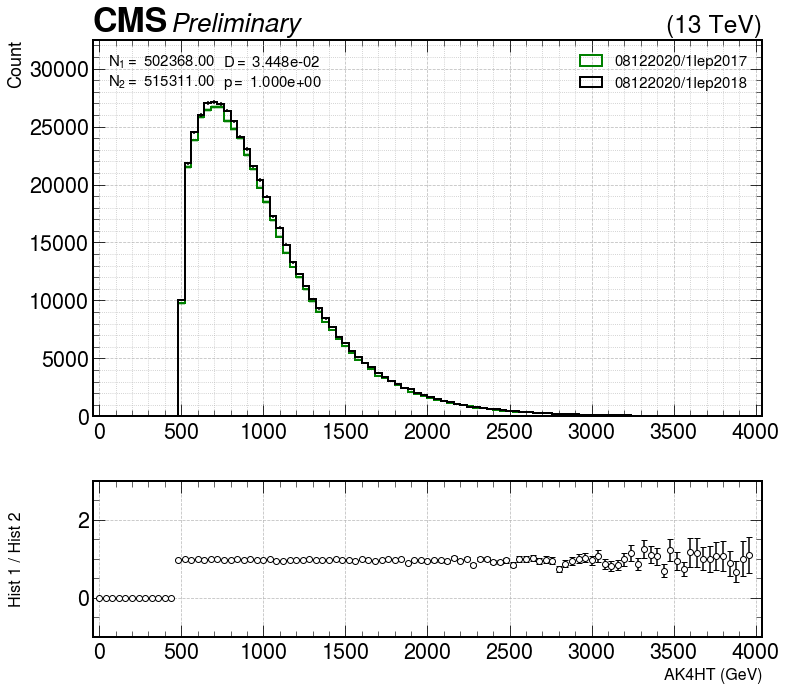

In [20]:
# plot the entire sample collection (i.e. pre-selection) without weights
plot_hist(
    branchOneSort,sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    branchTwoSort,sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins,"",False,False,""
)


### Plot the pre-selection distributions with weights

/usr/local/bin/start_ipykernel.py:193: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


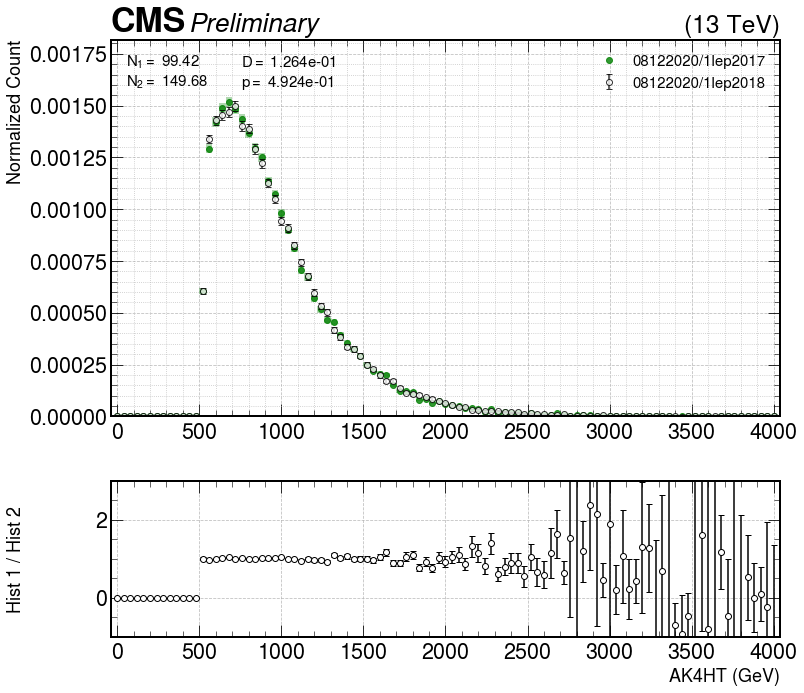

In [21]:
plot_weighted_hist(
    histWgtOne, histErrOne, sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    histWgtTwo, histErrTwo, sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins, "with weights", True, ""
)

### Plot the histograms after selection

/usr/local/bin/start_ipykernel.py:108: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


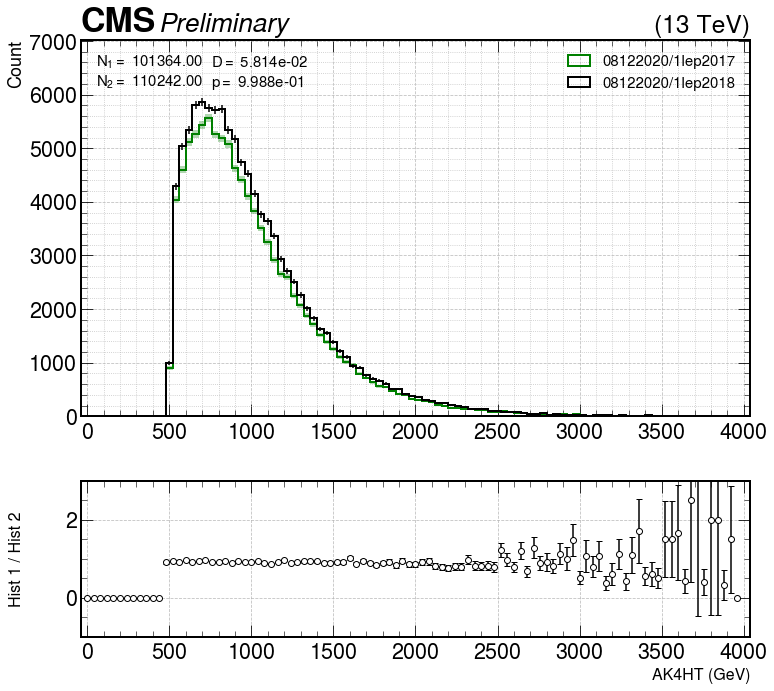

In [22]:
plot_hist(
    branchCutOne,sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    branchCutTwo,sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins,r"after selection ($n_j\geq${}, $n_b\geq${})".format(nJets,bJets),False,False,""
)

### Plot the histograms after selection with weights

/usr/local/bin/start_ipykernel.py:193: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


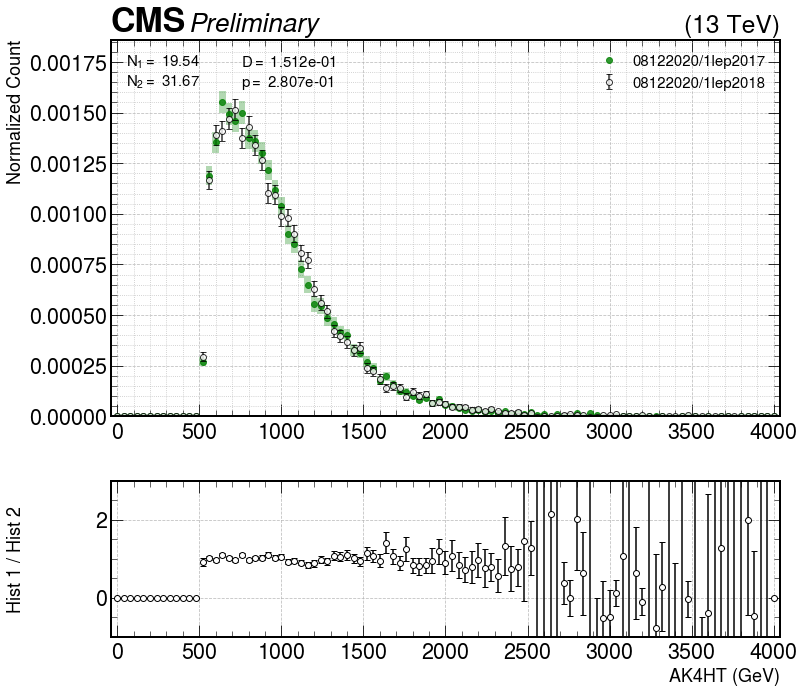

In [23]:
plot_weighted_hist(
    histWgtCutOne, histWgtErrOne, sampleDirOne.value.split("_")[4]+"/"+sampleDirOne.value.split("_")[1],
    histWgtCutTwo, histWgtErrTwo, sampleDirTwo.value.split("_")[4]+"/"+sampleDirTwo.value.split("_")[1],
    histBins, r"with weights after selection ($n_j\geq${}, $n_b\geq${})".format(nJets,bJets), True, ""
)

## Plot the correlation matrix

In [25]:
# populate the branches
histOne = {}
histTwo = {}
varList = np.asarray(varsList.varList["DNN"])[:,0]

indxOne = np.argwhere(varList == "leptonPt_MultiLepCalc")[0,0]
indxTwo = np.argwhere(varList == "corr_met_MultiLepCalc")[0,0]

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    histOne[file] = np.asarray(rootTreeOne[file].AsMatrix( varList ))
for file in sampleTwo.value:
    histTwo[file] = np.asarray(rootTreeTwo[file].AsMatrix( varList ))

In [26]:
histOneComb = np.concatenate([histOne[file] for file in sampleOne.value])
histTwoComb = np.concatenate([histTwo[file] for file in sampleTwo.value])

histOneSort = histOneComb[np.lexsort((histOneComb[:,indxTwo],histOneComb[:,indxOne]))]
histTwoSort = histTwoComb[np.lexsort((histTwoComb[:,indxTwo],histTwoComb[:,indxOne]))]

histCutOne = histOneSort[cutMaskOne.astype(bool)]
histCutTwo = histTwoSort[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 51.66 seconds...


In [27]:
pdCutOne = pd.DataFrame(histCutOne,columns = varList)
pdCutTwo = pd.DataFrame(histCutTwo,columns = varList)

In [28]:
startTime = time.time()
pdCorrOne = pdCutOne.corr()
pdCorrTwo = pdCutTwo.corr()
print("Finished evaluating in {} seconds".format(time.time()-startTime))

Finished evaluating in 28.987362384796143 seconds


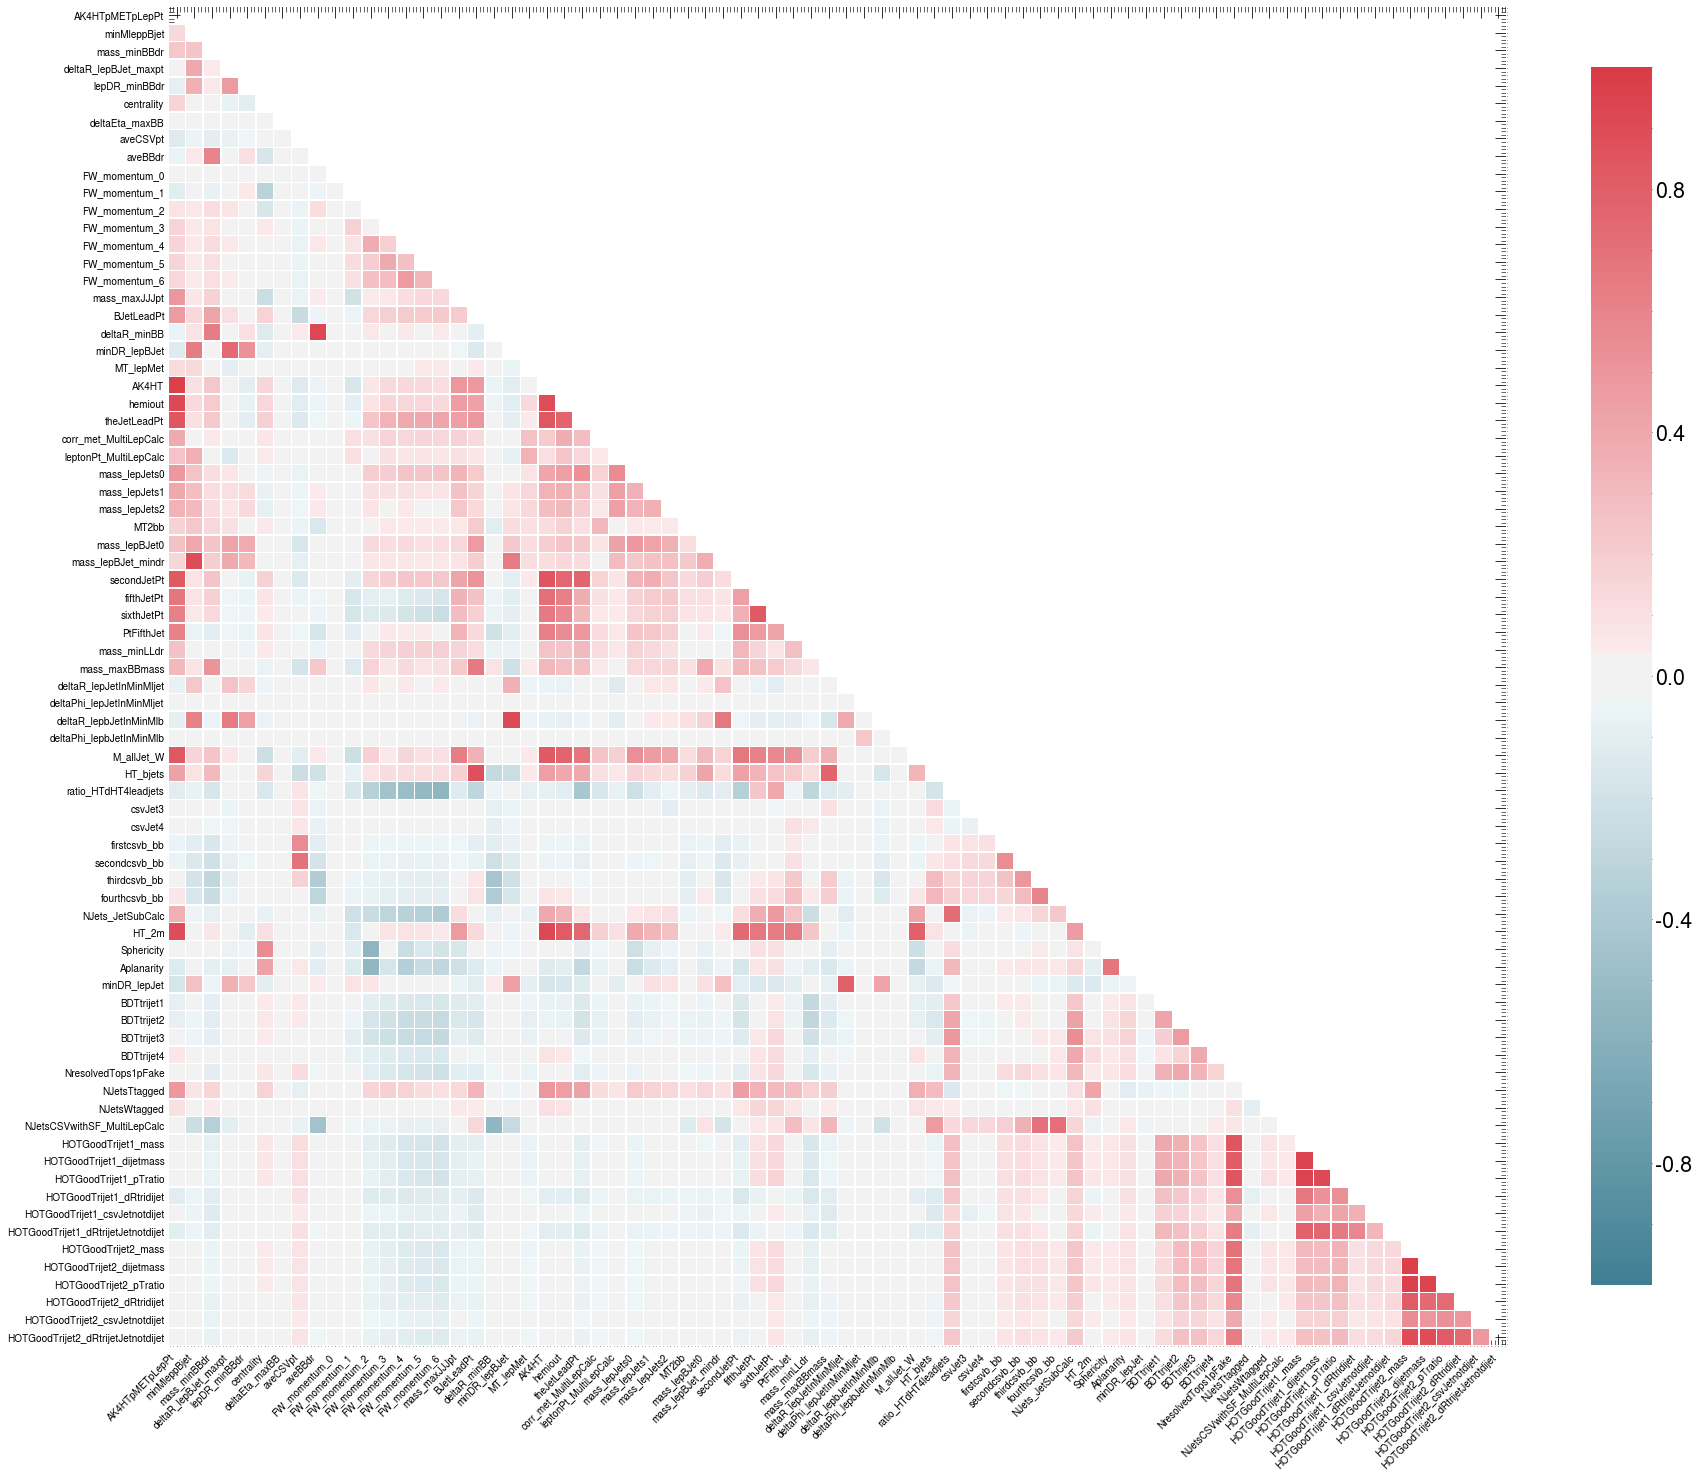

In [29]:
mask = np.triu(np.ones_like(pdCorrOne, dtype=np.bool))

f,ax = plt.subplots(figsize=(30,28))
ax = sns.heatmap(
    pdCorrOne,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    linewidth=.5,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={"shrink":.8}
)

#fix the x and y axis labels to be more readable
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',  
    fontsize= 10
    )
ax.set_yticklabels(
    ax.get_yticklabels(), 
    horizontalalignment='right',  
    fontsize=10
    )
#if you think it would be more readable with a lighter font, use fontweight='light'
plt.show()


## Plot the correlation matrix showing only highly correlated variables
Choose a correlation threshold (as a decimal)

In [30]:
#Set the correlation threshold to whatever you like
corrThresh = float(input("Enter the correlation threshold (decimal): "))

Enter the correlation threshold (decimal): 0.80


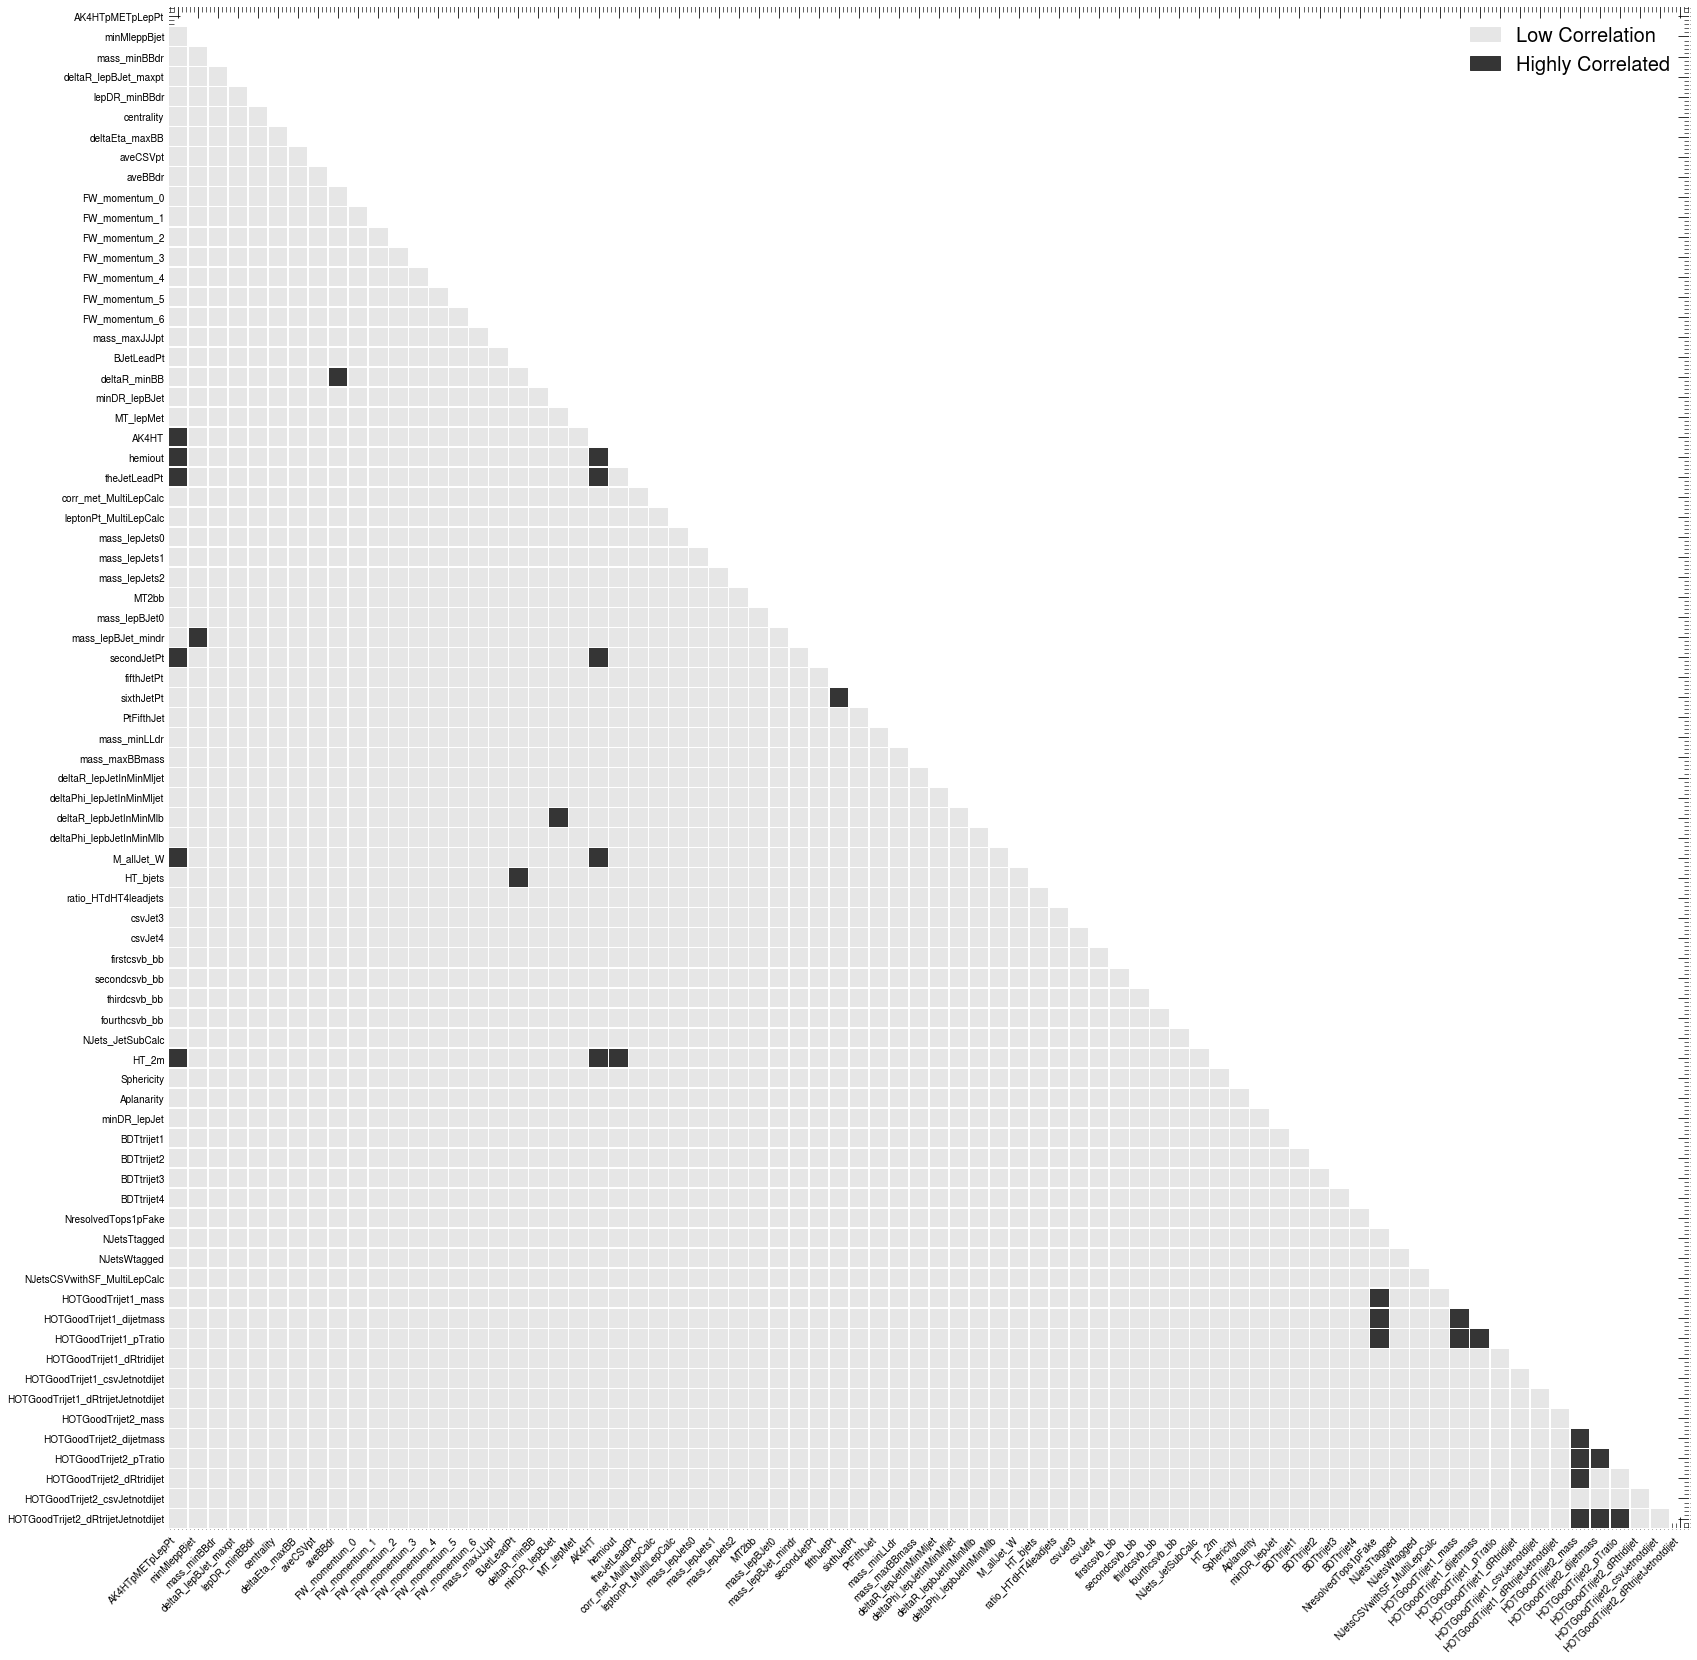

In [31]:
mask = np.triu(np.ones_like(pdCorrOne, dtype=np.bool))
#imported two formatting libraries
import matplotlib.colors
import matplotlib.patches as mpatches

#set the legend
red_patch = mpatches.Patch(color=(0.9, 0.9, 0.9), label='Low Correlation')
black_patch = mpatches.Patch(color=(0.207, 0.208, 0.209), label='Highly Correlated')

#set the colors, the segmented colormap, RBGA colors
colors = ((0.9, 0.9, 0.9), (0.207, 0.208, 0.209))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', colors, len(colors))

#plot the new correlation matrix
f,ax = plt.subplots(figsize=(30,28))
abspdCorrOne = abs(pdCorrOne) #easier to take the absolute value of our correlations, as we want strong correlations on both ends

ax = sns.heatmap(
    abspdCorrOne,
    mask=mask,
    vmin=0, vmax=1, center=corrThresh,
    cmap = cmap,
    square=True,
    linewidth=.5,
    xticklabels = True,
    yticklabels = True,
    cbar = False
)
#fix the x and y axis labels to be more readable
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',  
    fontsize= 10
    )
ax.set_yticklabels(
    ax.get_yticklabels(), 
    horizontalalignment='right',  
    fontsize= 10
    )
#if you think it would be more readable with a lighter font, use fontweight='light'

plt.legend(handles=[red_patch, black_patch], fontsize=20)
plt.show()

Define a method for compiling all the correlated pairs based on the highly correlated matrix

In [32]:
def getCorrelatedPairs(corrMatrix,corrCut,varNames):
    correlatedPairs = {}
    for i in np.range(np.shape(corrMatrix)[0] - 1):
        correlatedPairs[i] = [i]
        for j in np.arange(i+1,np.shape(corrMatrix)[1]):
            if abs(corrMatrix[i,j]) >= corrCut:
                print("{} and {} are {:.2f} % correlated.".format(
                    varNames[i], varNames[j], corrMatrix[i,j]
                )
                     )
                correlatedPairs[i].append(j)
        if len(correlatedPairs[i]) == 1: del correlatedPairs[i]
    

In [33]:
corrCut = corrThresh
corrGroups = {}
corrMatrix = pdCorrOne.to_numpy()
names = pdCorrOne.keys()
for i in np.arange(corrMatrix.shape[0] - 1):
    corrGroups[names[i]] = [names[i]]
    for j in np.arange(i+1,corrMatrix.shape[1]):
        if abs(corrMatrix[i,j]) >= corrCut:
            corrGroups[names[i]].append(names[j])
    if len(corrGroups[names[i]]) == 1: del corrGroups[names[i]]

Combine the correlated pairs into groups where all pairs with shared variables belong to the same group.  Each correlated group will have a unique set of variables.

In [34]:
corrGroupsUnique = {}
varKeys = list(corrGroups.keys())
skip = False
for keyIndx, key in enumerate(varKeys):
    if key not in list(corrGroups.keys()): skip = True
    if skip:
        skip = False
        continue
    entries = corrGroups[key]
    for keyIndx2 in np.arange(keyIndx+1,len(varKeys)):
        if varKeys[keyIndx2] in corrGroups[key]:
            entries.extend(corrGroups[varKeys[keyIndx2]])
            del corrGroups[varKeys[keyIndx2]]
    corrGroupsUnique[key] = set(list(entries))

In [35]:
combinations = 1
for key in list(corrGroupsUnique.keys()):
    print("{}: {} members".format(key,len(corrGroupsUnique[key])))
    combinations *= len(corrGroupsUnique[key])
print("{} total possible combinations.".format(combinations))

AK4HTpMETpLepPt: 7 members
minMleppBjet: 2 members
aveBBdr: 2 members
BJetLeadPt: 2 members
minDR_lepBJet: 2 members
fifthJetPt: 2 members
NresolvedTops1pFake: 4 members
HOTGoodTrijet2_mass: 5 members
4480 total possible combinations.


### Choose a subset of variables to view the correlation matrix

In [36]:
#allows user to select variables from dropdown 
print("Choose the variables (ctrl + mouse) you would like to correlate:")
variiList = []
for i in varsList.varList["DNN"]:
    variiList.append(i)
    
variList = [item[0] for item in variiList]

chooseVariables = widgets.SelectMultiple( options = variList )
chooseVariables

Choose the variables (ctrl + mouse) you would like to correlate:


SelectMultiple(options=('AK4HTpMETpLepPt', 'minMleppBjet', 'mass_minBBdr', 'deltaR_lepBJet_maxpt', 'lepDR_minB…

In [53]:
#makes the selected variables into a list
newVariables = []
for i in chooseVariables.value:
    newVariables.append(i)

In [54]:
# populate the branches
histOneA = {}
histTwoA = {}
varListA = np.asarray(newVariables)

indxOneA = np.argwhere(varListA == "leptonPt_MultiLepCalc")
indxTwoA = np.argwhere(varListA == "corr_met_MultiLepCalc")

startTime = time.time()
# want to sort these by a similar variable (i.e. leptonpt_multilepcalc) because root doesn't load in the data in the correct order so necessary to sort
for file in sampleOne.value:
    histOneA[file] = np.asarray(rootTreeOne[file].AsMatrix( varListA ))
for file in sampleTwo.value:
    histTwoA[file] = np.asarray(rootTreeTwo[file].AsMatrix( varListA ))

In [55]:
histOneCombA = np.concatenate([histOneA[file] for file in sampleOne.value])
histTwoCombA = np.concatenate([histTwoA[file] for file in sampleTwo.value])

#histOneSortA = histOneCombA[np.lexsort((histOneCombA[:,indxTwoA],histOneCombA[:,indxOneA]))]
#histTwoSortA = histTwoCombA[np.lexsort((histTwoCombA[:,indxTwoA],histTwoCombA[:,indxOneA]))]

#print(histOneSortA.shape)

histCutOneA = histOneCombA[cutMaskOne.astype(bool)]
histCutTwoA = histTwoCombA[cutMaskTwo.astype(bool)]

print("Finished applying selection to input variables in {:.2f} seconds...".format(time.time()-startTime))

Finished applying selection to input variables in 6.79 seconds...


Calculate the correlation matrix

In [56]:
pdCutOneA = pd.DataFrame(histCutOneA,columns = varListA)
pdCutTwoA = pd.DataFrame(histCutTwoA,columns = varListA)

In [57]:
startTime = time.time()
pdCorrOneA = pdCutOneA.corr()
pdCorrTwoA = pdCutTwoA.corr()
print("Finished evaluating in {} seconds".format(time.time()-startTime))

Finished evaluating in 0.01866436004638672 seconds


### Visualize the subset of variables

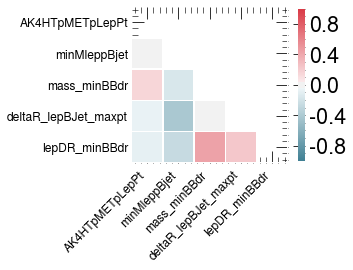

In [63]:
mask = np.triu(np.ones_like(pdCorrOneA, dtype=np.bool))
f,ax = plt.subplots(figsize=(len(pdCorrOneA)/2+1,len(pdCorrOneA)/2+1))
ax = sns.heatmap(
    pdCorrOneA,
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    xticklabels = True,
    yticklabels = True,
    linewidth=.5,
    cbar_kws={"shrink":.8}
)

#fix the x and y axis labels to be more readable
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',  
    fontsize=12
    )
ax.set_yticklabels(
    ax.get_yticklabels(), 
    rotation=0,
    horizontalalignment='right',  
    fontsize=12
    )
#if you think it would be more readable with a lighter font, use fontweight='light'
plt.show()


Identify which of the subset of variables are highly correlated

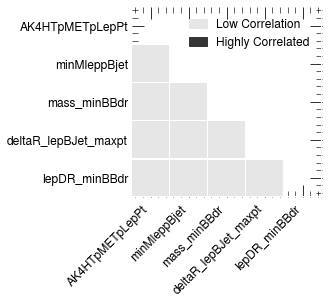

In [65]:
mask = np.triu(np.ones_like(pdCorrOneA, dtype=np.bool))
#imported two formatting libraries
import matplotlib.colors
import matplotlib.patches as mpatches

#set the legend
red_patch = mpatches.Patch(color=(0.9, 0.9, 0.9), label='Low Correlation')
black_patch = mpatches.Patch(color=(0.207, 0.208, 0.209), label='Highly Correlated')

#set the colors, the segmented colormap, RBGA colors
colors = ((0.9, 0.9, 0.9), (0.207, 0.208, 0.209))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', colors, len(colors))

#plot the new correlation matrix
f,ax = plt.subplots(figsize=(len(pdCorrOneA)/2+1,len(pdCorrOneA)/2+1))
abspdCorrOneA = abs(pdCorrOneA) #easier to take the absolute value of our correlations, as we want strong correlations on both ends

ax = sns.heatmap(
    abspdCorrOneA,
    mask=mask,
    vmin=0, vmax=1, center=corrThresh,
    cmap = cmap,
    square=True,
    xticklabels = True,
    yticklabels = True,
    linewidth=.5,
    cbar = False
)
#fix the x and y axis labels to be more readable
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',  
    fontsize= 12
    )
ax.set_yticklabels(
    ax.get_yticklabels(), 
    rotation=0,
    horizontalalignment='right',  
    fontsize=12
    )
#if you think it would be more readable with a lighter font, use fontweight='light'

plt.legend(handles=[red_patch, black_patch], fontsize=12)
plt.show()